In [3]:
#!pip install shapely
#!pip install geopandas

     |████████████████████████████████| 1.0 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 962 kB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 19.4 MB/s eta 0:00:01
     |████████████████████████████████| 10.9 MB 23.0 MB/s eta 0:00:01


In [4]:
#import Libraries
import requests
import lxml.html as lh
import bs4 as bs
import urllib.request
import numpy as np 
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

In [5]:
#Get the data from url
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
res = requests.get(url)
soup = bs.BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))
data.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [6]:
#Processing Data
data.rename(columns = {'Postal Code': 'Postcode'}, inplace = True)

#Choosing only data where field Borough doesn't have not assigned value
raw_data_selected = data[data['Borough'] != 'Not assigned']

#Grouping Data
raw_data_selected = raw_data_selected.groupby(['Borough', 'Postcode'], as_index=False).agg(','.join)

#Replacing values in Neighbourhood field with Borough where Neighbourhood is not assigned
raw_data_selected['Neighbourhood'] = np.where(raw_data_selected['Neighbourhood'] == 'Not assigned', raw_data_selected['Borough'], raw_data_selected['Neighbourhood'])
raw_data_selected.shape

(103, 3)

In [7]:
#Geoprocessing

geospatial_url = "https://cocl.us/Geospatial_data"
geospatial_data = pd.read_csv(geospatial_url)
geospatial_data.head()

# Renaming the columns
geospatial_data.columns = ['Postcode', 'Latitude', 'Longitude']
geospatial_data.columns

merged_data['Coordinates'] = list(zip(merged_data['Latitude'], merged_data['Longitude']))

NameError: name 'merged_data' is not defined

In [11]:
#Merging dataframes
merged_data = pd.merge(raw_data_selected, geospatial_data, on='Postcode')
merged_data['Coordinates'] = list(zip(merged_data['Latitude'], merged_data['Longitude']))
merged_data['Coordinates'] = merged_data['Coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(merged_data, geometry='Coordinates')
gdf.head()

,Borough,Postcode,Neighbourhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,POINT (43.72802 -79.38879)
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,POINT (43.71275 -79.39020)
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,POINT (43.71538 -79.40568)
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,POINT (43.70432 -79.38879)
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,POINT (43.68957 -79.38316)


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


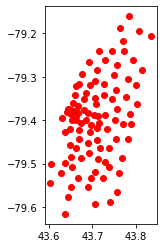

In [12]:
# set up map
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ax = cities[cities.name == "Toronto"].plot(
    color='green', edgecolor='black')
# plot and show
gdf.plot(ax=ax, color='red')

plt.show()

In [17]:
# import map rendering library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON 
import geopy

# use geopy to obtain latitude/longitude of Toronto.
# coordinates will be used for map visualization

address = 'Toronto, Ontario'

geolocator = geopy.Nominatim(user_agent="ny_explorer", timeout=30)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto 43.6534817, -79.3839347.


In [18]:
!pip install folium

     |████████████████████████████████| 93 kB 2.1 MB/s eta 0:00:011


In [20]:
import folium

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map based on coordinates of postcode
for lat, lng, neighbourhood in zip(gdf['Latitude'], gdf['Longitude'], gdf['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [21]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'JRG2WVLJKBPVXW3TB2L3NGNSGPNFBBGRDERMQU4OSN3ZMDQF' # your Foursquare ID
CLIENT_SECRET = 'H3DKQHPVZJJIPF4MKAK5AUJ3PNKAEVQ3OWPSY3ALCCUQWE23' # your Foursquare Secret
VERSION = '20161225' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JRG2WVLJKBPVXW3TB2L3NGNSGPNFBBGRDERMQU4OSN3ZMDQF
CLIENT_SECRET:H3DKQHPVZJJIPF4MKAK5AUJ3PNKAEVQ3OWPSY3ALCCUQWE23


In [23]:
# define limit = 5 (limit to 5 venues only) & radius = 500 (meters)
LIMIT = 5
radius = 500

location_list = [] # initiate a list to store data from Foursquare API requests

for neighbourhood, latitude, longitude in zip(gdf.Neighbourhood, gdf.Latitude, gdf.Longitude):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
    
    data = requests.get(url).json()
    
    # use len() to check if any data within "items" (len = 0 if nothing)
    length = len(data['response']['groups'][0]['items'])
    if length == 0:
        continue # skip the row if nothing is found
    else:
        venue = data['response']['groups'][0]['items'][0]['venue']
        
        # extract info within 'venue'
        name = venue['name']
        lat = venue['location']['lat']
        lon = venue['location']['lng']
        cat = venue['categories'][0]['name']
        
        location_list.append([(neighbourhood, latitude, longitude, name, lat, lon, cat)])

In [25]:
# create data frame based on 'Location_list'

temp = pd.DataFrame(x for row in location_list for x in row)
temp.columns = ['Neighbourhood','N_Latitude','N_Longitude','Venue','V_Latitude','V_Longitude','category']
temp.head()

print("{} nearby locations downloaded for {} neighbourhood.".format(len(temp.Venue), len(gdf.Neighbourhood)))

100 nearby locations downloaded for 103 neighbourhood.


In [26]:
cat = pd.get_dummies(temp.category) # one hot encoding with get_dummies()
df_01 = pd.concat([temp[['Neighbourhood']], cat], axis=1) # combine neighbourhood & category tables
df_01.head()

,Neighbourhood,Airport,Bakery,Bank,Bar,Baseball Field,Boutique,Breakfast Spot,Brewery,Café,...,Sandwich Place,Skating Rink,Sports Bar,Theme Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Warehouse Store,Wings Joint,Yoga Studio
0,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Davisville North,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"North Toronto West, Lawrence Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Davisville,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Moore Park, Summerhill East",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


# Cluster Analysis

In [27]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [28]:
df_02 = df_01.drop('Neighbourhood', axis=1)

n_group = 6 # we will group neighbourhoods into 6 clusters

# run k-means clustering
kmeans = KMeans(n_clusters=n_group, random_state=0).fit(df_02)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
df_01.insert(1, 'label', kmeans.labels_)

df_01.head() 


,Neighbourhood,label,Airport,Bakery,Bank,Bar,Baseball Field,Boutique,Breakfast Spot,Brewery,...,Sandwich Place,Skating Rink,Sports Bar,Theme Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Warehouse Store,Wings Joint,Yoga Studio
0,Lawrence Park,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Davisville North,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,"North Toronto West, Lawrence Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Davisville,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Moore Park, Summerhill East",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [29]:
# merge 'geo_toronto' & df_01

toronto_merged = pd.merge(gdf, df_01, on='Neighbourhood', how='right')
toronto_merged.head()

,Borough,Postcode,Neighbourhood,Latitude,Longitude,Coordinates,label,Airport,Bakery,Bank,...,Sandwich Place,Skating Rink,Sports Bar,Theme Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Warehouse Store,Wings Joint,Yoga Studio
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,POINT (43.72802 -79.38879),3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,POINT (43.71275 -79.39020),0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,POINT (43.71538 -79.40568),0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,POINT (43.70432 -79.38879),0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,POINT (43.68957 -79.38316),0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [35]:
from matplotlib import cm, colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(n_group)
ys = [i + x + (i*x)**2 for i in range(n_group)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters